<a href="https://colab.research.google.com/github/AgneseRT/ML_course_Pavia_23/blob/main/MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tumoral Histology Lung Cancer Identification
  
<b> Lung cancer is nowadays the major tumour-related mortality cause, with non-small cell lung cancer (NSCLC) corresponding to 85% of the incidences. Adenocarcinoma (Adk) and Squamous cell carcinoma (Scc) are two of the most common types of NSCLC, manage to distinguish between those is crucial to determine appropriate treatment decisions. The tumour presence is primarily diagnosed through imaging, then the information on the histological subtype is obtained through biopsy. Recently, Radiomics has allowed to extract quantitative information, labelled as Radiomics features, from medical images.  The idea behind is that histological and pathological information are hidden inside the images'pixel distribution so, in principle, is possible to correlate those features to tissue properties. Building a radiomics classifier that distinguishes between Adk and Scc could improve both patient life quality and clinical outcome. </b>

## Introduction

In this work, 3 different Dataset are considered, all provided by the I.R.C.C.S. San Matteo of Pavia. The imaging technique considered is the Computed Tomography (CT), which produces detailed cross-sectional body images through X-Rays. For each image considered, the Region of interest (ROI), corresponding to the tumoral lesion, has been segmented by clinicians. The ROI corresponds to the image part through which radiomics features are extracted.
For each dataset, just patients with complete information are considered (CT acquisition, ROI, and target).
The first dataset contains 135 patients, the second one 56, and the third one 30. The datasets are private, as an example an image is shown.

![picture](https://drive.google.com/uc?export=view&id=1rOZGJmM5bG0mgGf9POB9e8CfXEpdcACT)   

Pyradiomics has been used for features extraction (https://pyradiomics.readthedocs.io/en/latest/). All radiomics features are sensitive to images parameters, in particular to the grey scale and to the voxel dimension. For this reason, is important to normalize the images before extracting the features. CT images grey scale spans from black to white and is defined by the Hounsfield Unit (HU), which range is [-1000, +3000]. This range is the same per each CT image, so it is not necessary to normalize the grey levels between the images. Different is the case of voxels'size, which varies from image to image. Every image has been resampled to an isotropic voxel with a linear dimension of 0.8 mm.

Considering that the whole dataset was composed by 221 patients, I applied a well-known data augmentation method in this field, rotating the images of the three dataset.
To do so is necessary to:
- import nibabel as nib (Python package dedicated to the nifti images)
- read images: image = nib.read(path to the image)
- extract the data from the image image_data = image.get_fdata() (np array)
- define the rotation matrix (in this case I have used (1, 0, 2))
- transpose the image_data
- define the new image considering the transposed data and the affine matrix of the original data

It is necessary to apply the procedure both to the images and to the ROI, and randomly check that the transposed image is actually mirroring the original one.
Once the transposed datasets are available the features are extracted from these to enlarge the dataset.


In [ ]:
!pip install precision-medicine-toolbox

In [22]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import balanced_accuracy_score, classification_report, confusion_matrix, roc_curve, roc_auc_score, auc, accuracy_score
from sklearn.preprocessing import StandardScaler
from pmtool.AnalysisBox import AnalysisBox
from pmtool.ToolBox import ToolBox
import warnings
import xgboost as xgb

%matplotlib inline

In [5]:
# Data path definition
!wget -O dataset_scc.xlsx  https://docs.google.com/spreadsheets/d/1Ntq-naifbGKA1FKT2xyDJSKD2TZkrxUQ/edit?usp=drive_link&ouid=117926522194505989049&rtpof=true&sd=true
#pd.read_excel('https://docs.google.com/spreadsheets/d/1Ntq-naifbGKA1FKT2xyDJSKD2TZkrxUQ/edit?usp=drive_link&ouid=117926522194505989049&rtpof=true&sd=true')._get_numeric_data()
#dir = '/content/drive/MyDrive/Progetto_ML/'
#df = pd.read_excel(os.path.join(dir, 'dataset_scc.xlsx'))._get_numeric_data()


--2023-08-08 19:49:52--  https://docs.google.com/spreadsheets/d/1Ntq-naifbGKA1FKT2xyDJSKD2TZkrxUQ/edit?usp=drive_link
Resolving docs.google.com (docs.google.com)... 173.194.69.139, 173.194.69.100, 173.194.69.102, ...
Connecting to docs.google.com (docs.google.com)|173.194.69.139|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘dataset_scc.xlsx’

dataset_scc.xlsx        [  <=>               ]   1.08M  4.32MB/s    in 0.3s    

2023-08-08 19:49:53 (4.32 MB/s) - ‘dataset_scc.xlsx’ saved [1136619]



In [23]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [37]:
dir = '/content/drive/MyDrive/Progetto_ML/'
df = pd.read_excel(os.path.join(dir, 'dataset_scc.xlsx'))._get_numeric_data()

In [246]:
# Defining features and target
features = df.iloc[:,:-1]
target = df.iloc[:,-1]
print(features.shape, target.shape)

(438, 104) (438,)


In [247]:
# Shuffle the data, splitting them into a training and a validation dataset
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(features, target, test_size=0.33)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)
del features, target

(293, 104) (145, 104) (293,) (145,)


# Exploratory data analysis: Features reduction and selection
As first step the dataset is explored to look at the data, understand the distribution of the features, consider the presence of nan, identify the non-correlated features, and select the features through which build the model.
Features selection will be performed using Recursive Feature Elimination (RFE)
(https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html).



In [40]:
features_list = list(X_train.columns)
print (len(features_list))

104


In [41]:
# let's list the parameters of our features dataset
parameters = {
    'feature_path': os.path.join(dir,'dataset_scc.xlsx'), # path to csv/xls file with features
    'outcome_path': os.path.join(dir,'dataset_scc.xlsx'), #path to csv/xls file with outcome (in our case - the same file)
    'patient_column': 'ID',
    'patient_in_outcome_column': 'ID',
    'outcome_column': 'Scc',
    'feature_column': features_list,
    }
# initializing the dataset, containing features
fs = AnalysisBox(**parameters)

Number of observations: 438
Class labels: ['0' '1']
Classes balance: [0.591324200913242, 0.408675799086758]


In [42]:
#Drop Nan
print('Initial amount of features: ', len(X_train.columns))
fs.handle_nan(axis=1)
print('Amount of features after exclusion of NaN values: ', len(X_train.columns))

Initial amount of features:  104
Number of observations: 438
Class labels: ['0' '1']
Classes balance: [0.591324200913242, 0.408675799086758]
Amount of features after exclusion of NaN values:  104


In [43]:
#Selection of the features, which are not 'highly intercorrelated' (correlation is defined by Spearman coefficient);
warnings.filterwarnings("ignore", category=DeprecationWarning)
def selectNonIntercorrelated(df_in, ftrs, corr_th):
    corr_matrix = df_in.corr(method='spearman').abs()
    mean_absolute_corr = corr_matrix.mean()
    intercorrelated_features_set = []
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
    high_corrs = upper.where(upper > corr_th).dropna(how='all', axis=1).dropna(how='all', axis=0)

    for feature in high_corrs.columns:
        mean_absolute_main = mean_absolute_corr[feature]
        correlated_with_feature = high_corrs[feature].index[pd.notnull(high_corrs[feature])]
        for each_correlated_feature in correlated_with_feature:
            mean_absolute = mean_absolute_corr[each_correlated_feature]
            if mean_absolute_main > mean_absolute:
                if feature not in intercorrelated_features_set:
                    intercorrelated_features_set.append(feature)
            else:
                if each_correlated_feature not in intercorrelated_features_set:
                    intercorrelated_features_set.append(each_correlated_feature)

    non_intercorrelated_features_set = [e for e in ftrs if e not in intercorrelated_features_set]

    print ('Non intercorrelated features: ', non_intercorrelated_features_set)

    return non_intercorrelated_features_set
features_non_intercorrelated = selectNonIntercorrelated(X_train, features_list,  0.9)
print ('Number of non-intercorrelated features: ', len(features_non_intercorrelated))

Non intercorrelated features:  ['original_shape_Flatness', 'original_shape_MajorAxisLength', 'original_shape_Sphericity', 'original_shape_SurfaceVolumeRatio', 'original_firstorder_90Percentile', 'original_firstorder_InterquartileRange', 'original_firstorder_Kurtosis', 'original_firstorder_Maximum', 'original_firstorder_Mean', 'original_firstorder_Median', 'original_firstorder_Minimum', 'original_firstorder_Range', 'original_firstorder_Skewness', 'original_firstorder_TotalEnergy', 'original_firstorder_Variance', 'original_glcm_JointAverage', 'original_glcm_ClusterShade', 'original_glcm_Correlation', 'original_glcm_Imc1', 'original_glcm_Imc2', 'original_glcm_InverseVariance', 'original_glrlm_LongRunLowGrayLevelEmphasis', 'original_glrlm_RunEntropy', 'original_glszm_GrayLevelNonUniformity', 'original_glszm_GrayLevelVariance', 'original_glszm_LowGrayLevelZoneEmphasis', 'original_glszm_SizeZoneNonUniformity', 'original_glszm_SmallAreaEmphasis', 'original_glszm_ZoneEntropy', 'original_gldm_D

---
<b>Which is the optimal number of features to selected through RFE? <b>

There are some rules of thumb on how many features are need:  
* $int(\frac{N_{samples}}{10})$ (Abu-Mostafa, Y. S., Magdon-Ismail, M., & Lin, H. T. (2012). Learning from data. New York: AMLBook.)  
* $\sqrt{N_{samples}}$ (Hua, J., Xiong, Z., Lowey, J., Suh, E., & Dougherty, E. R. (2005). Optimal number of features as a function of sample size for various classification rules. Bioinformatics, 21(8), 1509-1515.)
----

In [44]:
print ('Number of samples in training dataset:', X_train.shape[0])
print ('Number of features to select according to Abu-Mostafa:', int(X_train.shape[0]/10) )
print ('Number of features to select according to Hua:', int(np.sqrt(X_train.shape[0])))

Number of samples in training dataset: 293
Number of features to select according to Abu-Mostafa: 29
Number of features to select according to Hua: 17


It's better to chose the lower number of features since the dataset is not large.

In [45]:
# RFE based on Random Forest Classifier, RFC (https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html).

estimator = RandomForestClassifier(n_estimators=100, random_state=np.random.seed(42))
selector = RFE(estimator, n_features_to_select=17, step=1)
selector = selector.fit(X_train[features_non_intercorrelated], y_train)
support = selector.get_support()
selected_features_set = X_train[features_non_intercorrelated].loc[:, support].columns.tolist()

print (selected_features_set)

['original_shape_Flatness', 'original_shape_MajorAxisLength', 'original_shape_Sphericity', 'original_shape_SurfaceVolumeRatio', 'original_firstorder_Kurtosis', 'original_firstorder_Maximum', 'original_firstorder_Minimum', 'original_firstorder_Range', 'original_firstorder_Skewness', 'original_firstorder_TotalEnergy', 'original_firstorder_Variance', 'original_glcm_InverseVariance', 'original_glrlm_RunEntropy', 'original_glszm_GrayLevelNonUniformity', 'original_glszm_GrayLevelVariance', 'original_glszm_LowGrayLevelZoneEmphasis', 'original_gldm_DependenceEntropy']


Let's check if the number of selected features is actually the optimal one for this dataset through a datadriven method.

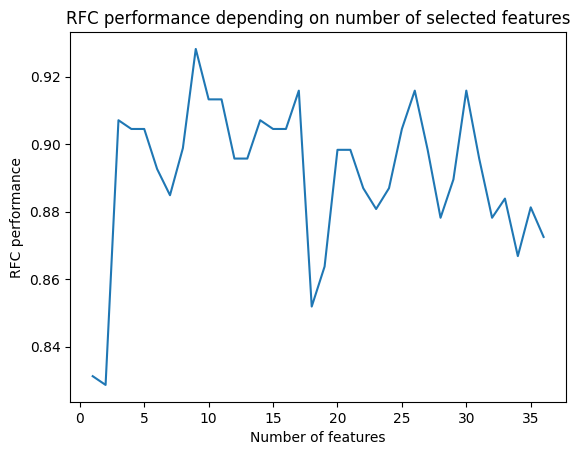

In [54]:
# ranking the features based on RFE results

features_ranks = pd.DataFrame({'Features': features_non_intercorrelated, 'Ranks': selector.ranking_})
features_ranks.sort_values(by='Ranks', inplace = True)

# taking one best feature first, building the RFC, estimating the performance;
# adding +1 next feature, repeating the steps to estimate the performance

ftrs_number_tuning = []
acc_tuning = []

for i in range (1, len(features_ranks)):

    ftrs_number_tuning.append(i)
    estimator_tuning = RandomForestClassifier(n_estimators=100, random_state=np.random.seed(42))
    estimator_tuning.fit(X_train[features_ranks['Features'][:i]], y_train)
    outcome_pred_tuning = estimator_tuning.predict(X_val[features_ranks['Features'][:i]])
    acc_tuning.append(balanced_accuracy_score(y_val, outcome_pred_tuning))

# plotting the results
plt.plot(ftrs_number_tuning, acc_tuning)
plt.xlabel('Number of features')
plt.ylabel('RFC performance')
plt.title('RFC performance depending on number of selected features')
plt.show()


In [248]:
X_train_sel = X_train[selected_features_set]
X_val_sel = X_val[selected_features_set]

In [249]:
X_val_sel.shape

(145, 17)

# MODEL 1: RFC

In [250]:
rfc = RandomForestClassifier(n_estimators=100, random_state=np.random.seed(42))
rfc.fit(X_train_sel, y_train)

RandomForestClassifier()

              precision    recall  f1-score   support

           0       0.93      0.88      0.91        93
           1       0.81      0.88      0.84        52

    accuracy                           0.88       145
   macro avg       0.87      0.88      0.88       145
weighted avg       0.89      0.88      0.88       145



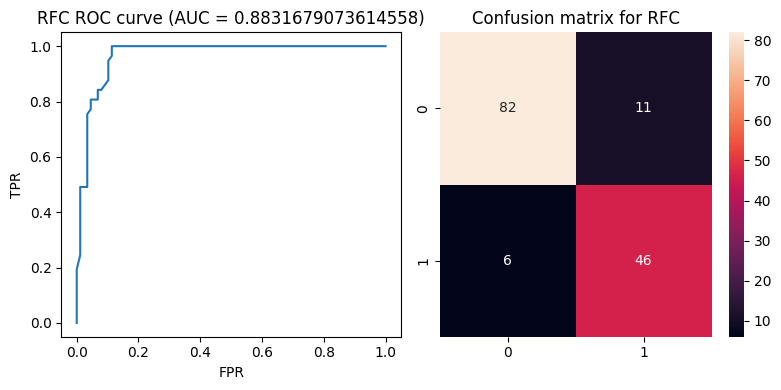

In [251]:
# Defining prediction for the testing set
outcome_pred_rfc = rfc.predict(X_val_sel)

#Eavluate performance through different metrics
print(classification_report(outcome_pred_rfc, y_val))

fpr, tpr, _ = roc_curve(y_val, rfc.predict_proba(X_val_sel)[:, 1])
roc_auc = roc_auc_score(outcome_pred_rfc, y_val)

cm = confusion_matrix(outcome_pred_rfc, y_val)

fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].plot(fpr, tpr)
axes[0].set_title('RFC ROC curve (AUC = {})'.format(roc_auc))
axes[0].set_xlabel('FPR')
axes[0].set_ylabel('TPR')

f = sns.heatmap(cm, annot=True)
axes[1].set_title('Confusion matrix for RFC')

plt.tight_layout()
plt.show()

#MODEL 2: XGBoost

In [252]:
#Model definition
dtrain = xgb.DMatrix(X_train_sel, label=y_train)
dtest = xgb.DMatrix(X_val_sel, label=y_val)
param = {'objective': 'binary:logistic', 'eval_metric': 'aucpr'}
evallist = [(dtest, 'eval'), (dtrain, 'train')]

In [253]:
#Training
num_round = 10
bst = xgb.train(param, dtrain, num_round, evallist)

outcome_pred_xgb = bst.predict(dtest)

[0]	eval-aucpr:0.63800	train-aucpr:0.87460
[1]	eval-aucpr:0.72529	train-aucpr:0.96463
[2]	eval-aucpr:0.80853	train-aucpr:0.98344
[3]	eval-aucpr:0.81304	train-aucpr:0.99356
[4]	eval-aucpr:0.81239	train-aucpr:0.99814
[5]	eval-aucpr:0.84649	train-aucpr:0.99918
[6]	eval-aucpr:0.85673	train-aucpr:0.99959
[7]	eval-aucpr:0.85715	train-aucpr:0.99980
[8]	eval-aucpr:0.83683	train-aucpr:0.99987
[9]	eval-aucpr:0.86266	train-aucpr:1.00000


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


              precision    recall  f1-score   support

           0       0.90      0.94      0.92        88
           1       0.91      0.84      0.87        57

    accuracy                           0.90       145
   macro avg       0.90      0.89      0.90       145
weighted avg       0.90      0.90      0.90       145



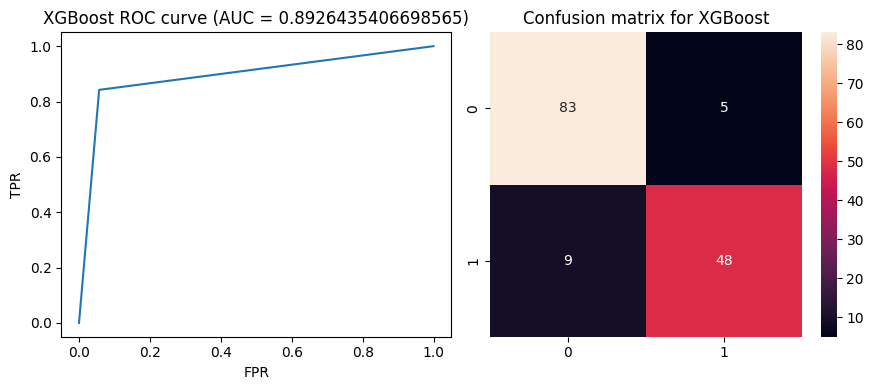

In [254]:
print (classification_report(y_val, outcome_pred_xgb>0.5))

fpr, tpr, _ = roc_curve(y_val, outcome_pred_xgb>0.5)
roc_auc = roc_auc_score(y_val, outcome_pred_xgb>0.5)

cm = confusion_matrix(y_val, outcome_pred_xgb>0.5)

fig, axes = plt.subplots(1, 2, figsize=(9, 4))
axes[0].plot(fpr, tpr)
axes[0].set_title('XGBoost ROC curve (AUC = {})'.format(roc_auc))
axes[0].set_xlabel('FPR')
axes[0].set_ylabel('TPR')

f = sns.heatmap(cm, annot=True)
axes[1].set_title('Confusion matrix for XGBoost')

plt.tight_layout()
plt.show()

# Multilayer Perceptron (MLP)

In [255]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten, Activation
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
from tensorflow.keras import metrics, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TerminateOnNaN
import tensorflow as tf

In [67]:
X = features = df.iloc[:,:-1]
Y =  target = df.iloc[:,-1]

In [ ]:
skf = StratifiedKFold(n_splits=5)

In [ ]:
fold_no = 1
for train_index, test_index in skf.split(X, Y):
  train = df.loc[train_index,:]
  test = df.loc[test_index,:]
  print('Fold',str(fold_no),'Class Ratio:',sum(test['Returned_Units'])/len(test['Returned_Units']))
  fold_no += 1

In [256]:
# Normalize the data
mean = np.mean(X_train_sel, axis=0)
X_train_sel -= mean
X_val_sel -= mean
std = np.std(X_train_sel, axis=0)
X_train_sel /= std
X_val_sel /= std

In [395]:
counts = np.bincount(y_train)
print(counts)
print(
    "Number of positive samples in training data: {} ({:.2f}% of total)".format(
        counts[1], 100 * float(counts[1]) / len(y_train)
    )
)

weight_for_0 = 1.0 / counts[0]
weight_for_1 = 1.0 / counts[1]
print(weight_for_0, weight_for_1)

[171 122]
Number of positive samples in training data: 122 (41.64% of total)
0.005847953216374269 0.00819672131147541


In [610]:
#Model building
input_shape = X_train_sel.shape[1]
dropoutRate = 0.25
#
inputArray = Input(shape=(input_shape,))
#
x = Dense(30, activation='relu')(inputArray)
x = Dropout(dropoutRate)(x)
#
x = Dense(15)(x)
x = Activation('relu')(x)
x = Dropout(dropoutRate)(x)
#
x = Dense(5, activation='sigmoid')(x)
#
output = Dense(1, activation='sigmoid')(x)
####
model = Model(inputs=inputArray, outputs=output)

In [611]:
# Set random seed for reproducibility
seed_value = 42
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

#Compile the model
model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(0.001), metrics='accuracy')
model.summary()

Model: "model_93"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_95 (InputLayer)       [(None, 17)]              0         
                                                                 
 dense_349 (Dense)           (None, 30)                540       
                                                                 
 dropout_201 (Dropout)       (None, 30)                0         
                                                                 
 dense_350 (Dense)           (None, 15)                465       
                                                                 
 activation_101 (Activation)  (None, 15)               0         
                                                                 
 dropout_202 (Dropout)       (None, 15)                0         
                                                                 
 dense_351 (Dense)           (None, 5)                 80 

In [612]:
# Parameters settings
callbacks = [EarlyStopping(monitor='val_loss', patience=10, verbose=1),
             ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1),
             TerminateOnNaN()]


batch_size = 32
n_epochs = 50

# train
history = model.fit(X_train_sel, y_train, epochs=n_epochs, batch_size=batch_size, verbose = 2,
                validation_data=(X_val_sel, y_val),
                callbacks = callbacks,
                )

Epoch 1/50
10/10 - 2s - loss: 0.7564 - accuracy: 0.4198 - val_loss: 0.7639 - val_accuracy: 0.4000 - lr: 0.0010 - 2s/epoch - 177ms/step
Epoch 2/50
10/10 - 0s - loss: 0.7396 - accuracy: 0.4164 - val_loss: 0.7388 - val_accuracy: 0.4000 - lr: 0.0010 - 70ms/epoch - 7ms/step
Epoch 3/50
10/10 - 0s - loss: 0.7182 - accuracy: 0.4300 - val_loss: 0.7192 - val_accuracy: 0.3586 - lr: 0.0010 - 74ms/epoch - 7ms/step
Epoch 4/50
10/10 - 0s - loss: 0.7146 - accuracy: 0.4198 - val_loss: 0.7040 - val_accuracy: 0.3862 - lr: 0.0010 - 71ms/epoch - 7ms/step
Epoch 5/50
10/10 - 0s - loss: 0.6975 - accuracy: 0.4812 - val_loss: 0.6918 - val_accuracy: 0.5241 - lr: 0.0010 - 82ms/epoch - 8ms/step
Epoch 6/50
10/10 - 0s - loss: 0.6800 - accuracy: 0.5734 - val_loss: 0.6812 - val_accuracy: 0.5724 - lr: 0.0010 - 70ms/epoch - 7ms/step
Epoch 7/50
10/10 - 0s - loss: 0.6830 - accuracy: 0.5427 - val_loss: 0.6727 - val_accuracy: 0.6069 - lr: 0.0010 - 67ms/epoch - 7ms/step
Epoch 8/50
10/10 - 0s - loss: 0.6627 - accuracy: 0.6587

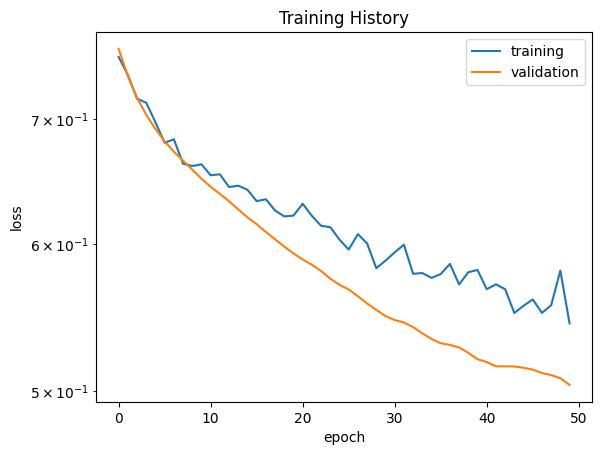

In [613]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.yscale('log')
plt.title('Training History')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

5/5 [==============================] - 0s 2ms/step


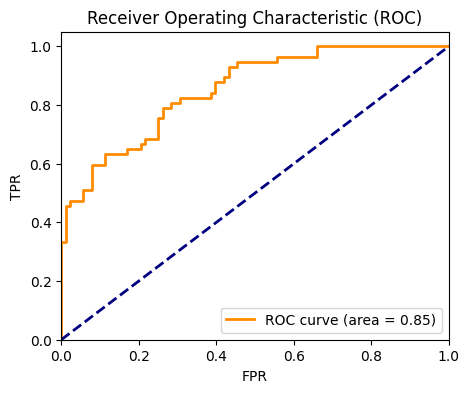

In [614]:
y_pred = model.predict(X_val_sel)

fpr, tpr, thresholds = roc_curve(y_val, y_pred)
roc_auc = roc_auc_score(y_val, y_pred)
plt.figure(figsize=(5, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

In [696]:
from tensorflow import keras
# Set random seed for reproducibility
seed_value = 42
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

model = keras.Sequential(
    [
        keras.layers.Dense(
            30, activation="relu", input_shape=(input_shape,)
        ),
        keras.layers.Dense(15, activation="relu"),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(5, activation="sigmoid"),
        keras.layers.Dense(1, activation="sigmoid"),
    ]
)
model.summary()

Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_427 (Dense)           (None, 30)                540       
                                                                 
 dense_428 (Dense)           (None, 15)                465       
                                                                 
 dropout_228 (Dropout)       (None, 15)                0         
                                                                 
 dense_429 (Dense)           (None, 5)                 80        
                                                                 
 dense_430 (Dense)           (None, 1)                 6         
                                                                 
Total params: 1,091
Trainable params: 1,091
Non-trainable params: 0
_________________________________________________________________


In [697]:
model.compile(
    optimizer=keras.optimizers.Adam(0.001), loss="binary_crossentropy", metrics='accuracy')

callbacks = [EarlyStopping(monitor='val_loss', patience=10, verbose=1),
             ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1),
             TerminateOnNaN()]


history = model.fit(
    X_train_sel,
    y_train,
    batch_size=32,
    epochs=50,
    verbose=2,
    callbacks=callbacks,
    validation_data=(X_val_sel, y_val),
    #class_weight=class_weight,
)

Epoch 1/50
10/10 - 3s - loss: 0.6955 - accuracy: 0.5631 - val_loss: 0.6858 - val_accuracy: 0.6069 - lr: 0.0010 - 3s/epoch - 261ms/step
Epoch 2/50
10/10 - 0s - loss: 0.6825 - accuracy: 0.5768 - val_loss: 0.6764 - val_accuracy: 0.6069 - lr: 0.0010 - 85ms/epoch - 8ms/step
Epoch 3/50
10/10 - 0s - loss: 0.6800 - accuracy: 0.5597 - val_loss: 0.6692 - val_accuracy: 0.6069 - lr: 0.0010 - 77ms/epoch - 8ms/step
Epoch 4/50
10/10 - 0s - loss: 0.6737 - accuracy: 0.5836 - val_loss: 0.6617 - val_accuracy: 0.6069 - lr: 0.0010 - 74ms/epoch - 7ms/step
Epoch 5/50
10/10 - 0s - loss: 0.6676 - accuracy: 0.5870 - val_loss: 0.6545 - val_accuracy: 0.6069 - lr: 0.0010 - 78ms/epoch - 8ms/step
Epoch 6/50
10/10 - 0s - loss: 0.6640 - accuracy: 0.5836 - val_loss: 0.6475 - val_accuracy: 0.6069 - lr: 0.0010 - 80ms/epoch - 8ms/step
Epoch 7/50
10/10 - 0s - loss: 0.6608 - accuracy: 0.5836 - val_loss: 0.6415 - val_accuracy: 0.6069 - lr: 0.0010 - 86ms/epoch - 9ms/step
Epoch 8/50
10/10 - 0s - loss: 0.6524 - accuracy: 0.5836

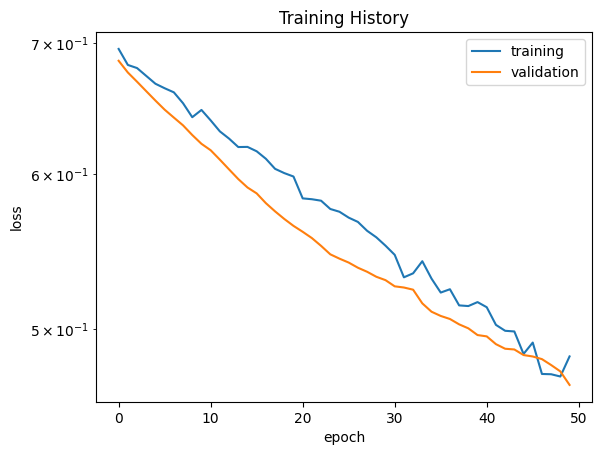

In [698]:
# plot training history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.yscale('log')
plt.title('Training History')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

5/5 [==============================] - 0s 2ms/step


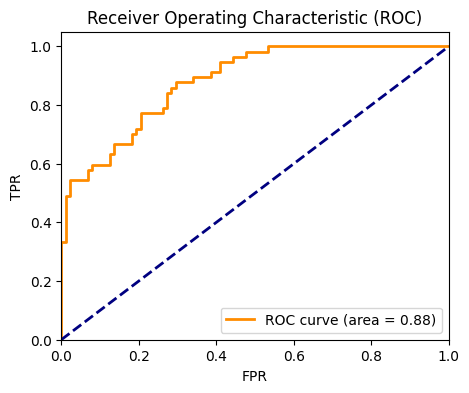

In [699]:
y_pred = model.predict(X_val_sel)

fpr, tpr, thresholds = roc_curve(y_val, y_pred)
roc_auc = roc_auc_score(y_val, y_pred)
plt.figure(figsize=(5, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()